Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Images From Google Drive


### Importing all the required libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Connecting To My Goolge Drive Where Data sets are loaded
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Test')

In [ ]:
# Checking number of images on each directory

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Define some parameters for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Assigning 80% of the images for training, and 20% for validation.

In [1]:
## Defining Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle = True, seed=123, validation_split=0.2,subset='training'
)

NameError: ignored

In [ ]:
## Defining validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle = True, seed=123, validation_split=0.2,subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize and ensuring one instance of all the nine classes present in the dataset

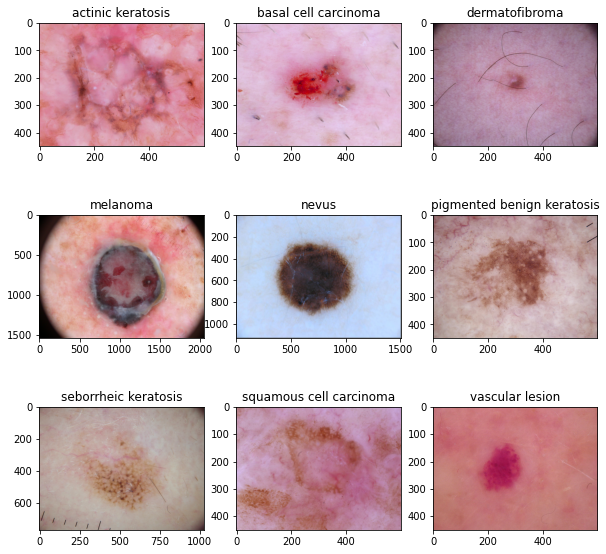

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - 1
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model-1
Choose an appropirate optimiser and loss function for model training 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Trainning the model-1

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 779s 10s/step - loss: 2.0615 - accuracy: 0.1931 - val_loss: 2.0473 - val_accuracy: 0.1902
Epoch 2/20
56/56 [==============================] - 502s 9s/step - loss: 2.0157 - accuracy: 0.2087 - val_loss: 1.9381 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 500s 9s/step - loss: 1.9118 - accuracy: 0.2656 - val_loss: 1.8691 - val_accuracy: 0.2752
Epoch 4/20
56/56 [==============================] - 500s 9s/step - loss: 1.8309 - accuracy: 0.3047 - val_loss: 1.7900 - val_accuracy: 0.3266
Epoch 5/20
56/56 [==============================] - 493s 9s/step - loss: 1.7973 - accuracy: 0.3186 - val_loss: 1.7568 - val_accuracy: 0.3333
Epoch 6/20
56/56 [==============================] - 497s 9s/step - loss: 1.6526 - accuracy: 0.3850 - val_loss: 1.7072 - val_accuracy: 0.3826
Epoch 7/20
56/56 [==============================] - 491s 9s/step - loss: 1.6102 - accuracy: 0.4113 - val_loss: 1.6703 - val_accuracy: 0.3647
Epoch 8/20
56/56 [=====

### Visualizing training of Model-1 results

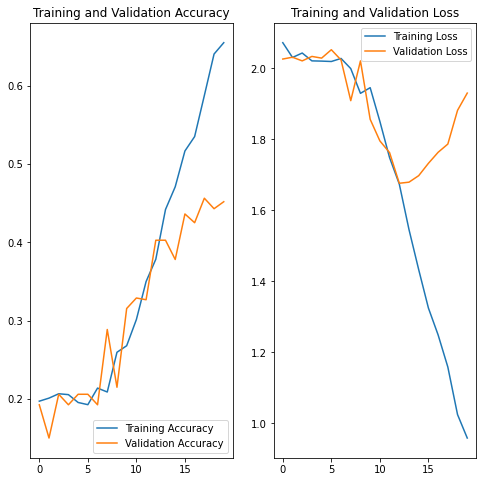

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### With above plot it is understand that the model not overfit, but the efficiency is poor, which may be because we just build a basic model

### Write your findings here

*   The Basic Model Accuracy seems very less.
*   Further we check data balance and model parameters




### Image Augmentation by manual to overcome unbalanced dataset

In [ ]:
## Choose an appropriate data Augmentation strategy
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

### Model-2
### Model Building with above Augmentated image set



In [ ]:
## Dropout layer if there is an evidence of overfitting in our findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model-2

In [ ]:
## Choose an appropriate optimiser and loss function for model training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model-2

In [ ]:
## Train the model for ~20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 90ms/step - loss: 2.0686 - accuracy: 0.1925 - val_loss: 2.0287 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 84ms/step - loss: 2.0248 - accuracy: 0.2009 - val_loss: 2.0325 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 5s 84ms/step - loss: 1.9789 - accuracy: 0.2589 - val_loss: 1.9775 - val_accuracy: 0.2796
Epoch 4/20
56/56 [==============================] - 5s 84ms/step - loss: 1.8659 - accuracy: 0.3103 - val_loss: 1.8409 - val_accuracy: 0.3132
Epoch 5/20
56/56 [==============================] - 5s 84ms/step - loss: 1.8418 - accuracy: 0.3214 - val_loss: 1.8058 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 5s 84ms/step - loss: 1.8618 - accuracy: 0.3047 - val_loss: 1.8312 - val_accuracy: 0.3266
Epoch 7/20
56/56 [==============================] - 5s 84ms/step - loss: 1.8188 - accuracy: 0.3214 - val_loss: 1.7803 - val_accuracy: 0.3266
Epoch 8/20
56

### Visualizing the results of Model-2

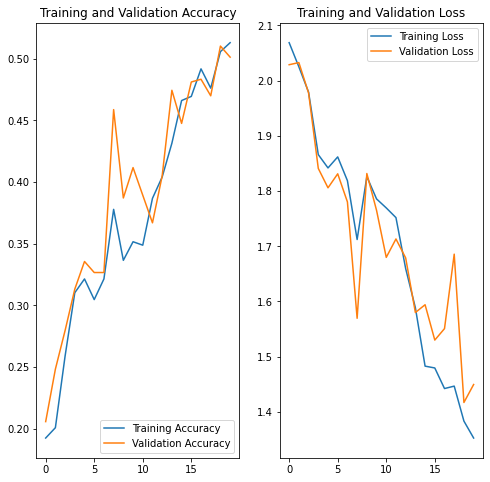

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After Augmentation the model training accuracy almost same but validation accuracy increased. plot seems there is a overfit, we will check further

#### **Model-2 Findings** Write your findings here: 
 - After augumentation the model training accuracy almost same.
 - the validation accuracy increased bit. plot seems there is a overfit, we will check further

### **Checking The data imbalance**


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

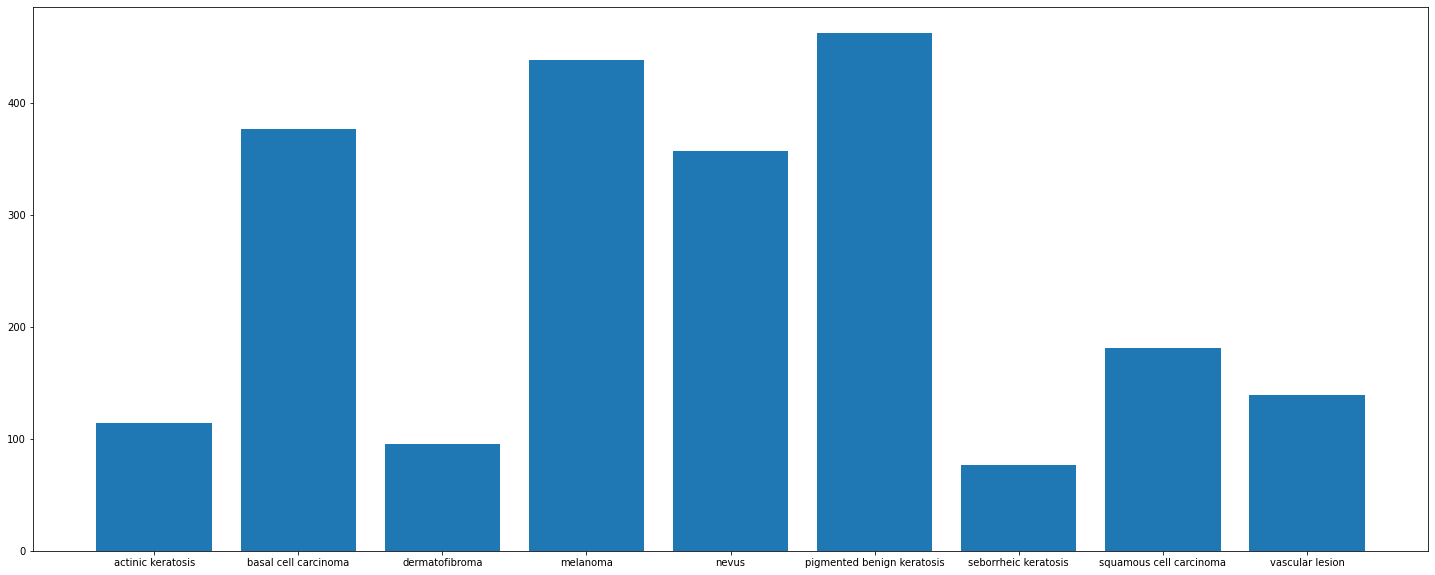

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### From above chart we able to understand that the data has class imbalancing issue

#### **Handling of the class imbalance:** 


In [ ]:
#Installation of Augmentor Libr
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD46ECF9F10>: 100%|██████████| 500/500 [00:11<00:00, 43.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD593C0F510>: 100%|██████████| 500/500 [00:12<00:00, 40.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD46EC2E290>: 100%|██████████| 500/500 [00:09<00:00, 50.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD46CBA74D0>: 100%|██████████| 500/500 [00:44<00:00, 11.17 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FD46EC2D0D0>: 100%|██████████| 500/500 [00:44<00:00, 11.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD46CB93A10>: 100%|██████████| 500/500 [00:09<00:00, 54.03 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD46ECF8290>: 100%|██████████| 500/500 [00:20<00:00, 24.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD46CBA7A10>: 100%|██████████| 500/500 [00:09<00:00, 55.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD46EC951D0>: 100%|██████████| 500/500 [00:09<00:00, 54.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
from glob import glob

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_727addf6-a5d6-4407-92a2-bd11b3099d0a.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031457.jpg_68dde257-7363-460f-b77a-2d4eb1194139.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031271.jpg_c8491911-3114-4925-9bfb-7f1a5e493079.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033860.jpg_27be65bc-ddfb-46b4-957f-f9635ca4dda2.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031827.jpg_275bf48e-696d-44bd-8444-798e91de7dc4.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_913c4900-25bf-4fc4-9398-bc3ae0065eee.jpg',
 '/content

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df=df2
#new_df = original_df.append(df2)
df2

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
...,...,...
4495,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4496,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4497,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4498,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis


In [ ]:
new_df['Label'].value_counts()

dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
nevus                         500
seborrheic keratosis          500
vascular lesion               500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer/Train")


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='training'
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='validation'
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Creating Model-3**

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compiling of Model-3 (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Trainning of Model-3**

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 23s 127ms/step - loss: 2.1212 - accuracy: 0.1886 - val_loss: 1.9061 - val_accuracy: 0.2695
Epoch 2/30
169/169 [==============================] - 20s 116ms/step - loss: 1.6937 - accuracy: 0.3591 - val_loss: 1.5390 - val_accuracy: 0.4128
Epoch 3/30
169/169 [==============================] - 20s 117ms/step - loss: 1.5399 - accuracy: 0.4253 - val_loss: 1.4515 - val_accuracy: 0.4625
Epoch 4/30
169/169 [==============================] - 20s 117ms/step - loss: 1.3917 - accuracy: 0.4931 - val_loss: 1.3561 - val_accuracy: 0.4937
Epoch 5/30
169/169 [==============================] - 20s 116ms/step - loss: 1.2465 - accuracy: 0.5393 - val_loss: 1.2252 - val_accuracy: 0.5449
Epoch 6/30
169/169 [==============================] - 21s 120ms/step - loss: 1.0702 - accuracy: 0.6092 - val_loss: 1.0569 - val_accuracy: 0.6258
Epoch 7/30
169/169 [==============================] - 20s 117ms/step - loss: 0.9074 - accuracy: 0.6703 - val_loss: 0.9814 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

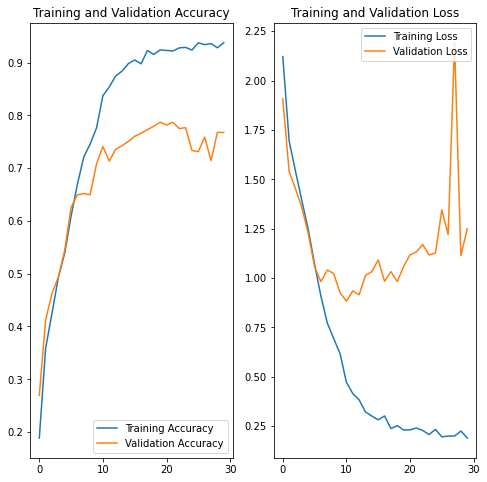

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Model-3 Summary**
- Now the model has better Trainning accuracy of 93 and validation accuracy of 75. 
- Model accuracy has been improved better after resolving class imbalancing by augmentation method.
- we can improve further by working on the model hyperparameters

